Analysis of Covid-19 based on available data from relevant governments.
This model is based on the work of Gianluca Malato:
https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

In [4]:
#Italian data
df = pd.read_csv("dpc-covid19-ita-andamento-nazionale.csv")
df = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv")

In [5]:
df

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,101,26,127,94,221,221,1,7,229,4324
1,2020-02-25 18:00:00,ITA,114,35,150,162,311,90,1,10,322,8623
2,2020-02-26 18:00:00,ITA,128,36,164,221,385,74,3,12,400,9587
3,2020-02-27 18:00:00,ITA,248,56,304,284,588,203,45,17,650,12014
4,2020-02-28 18:00:00,ITA,345,64,409,412,821,233,46,21,888,15695
5,2020-02-29 18:00:00,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,2020-03-01 18:00:00,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,2020-03-02 18:00:00,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,2020-03-03 18:00:00,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,2020-03-04 18:00:00,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837


In [6]:
# totale_casi contains the cumulative number of infected people to date.
df = df.loc[:,['data', 'totale_casi']]

In [7]:
date = df['data']

In [8]:
# get the number of days since the start of the year
FMT = '%Y-%m-%d %H:%M:%S'
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

In [9]:
df

,data,totale_casi
0,54,229
1,55,322
2,56,400
3,57,650
4,58,888
5,59,1128
6,60,1694
7,61,2036
8,62,2502
9,63,3089


In [13]:
df_g = df
df_g['Change'] = df_g['totale_casi'] - df_g['totale_casi'].shift(1)
df_g['Growth Factor'] = df_g['Change']/df_g['Change'].shift(1)

,data,totale_casi,Change,Growth Factor
0,54,229,NaN,NaN
1,55,322,93.0,NaN
2,56,400,78.0,0.838710
3,57,650,250.0,3.205128
4,58,888,238.0,0.952000
5,59,1128,240.0,1.008403
6,60,1694,566.0,2.358333
7,61,2036,342.0,0.604240
8,62,2502,466.0,1.362573
9,63,3089,587.0,1.259657


In [427]:
# logistic model
def logistic_model(x,a,b,c):
    return c / (1 + np.exp(-(x-b)/a))

In [428]:
#use curve_fit from scipy to estimate the parameter values and errors from data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [429]:
fit = curve_fit(logistic_model, x, y, p0=[3,108,25000])
fit

(array([3.84881368e+00, 7.13020759e+01, 2.96595572e+04]),
 array([[3.25124507e-02, 1.73376046e-01, 7.56954764e+02],
        [1.73376046e-01, 1.01646004e+00, 4.52366516e+03],
        [7.56954764e+02, 4.52366516e+03, 2.02594339e+07]]))

In [430]:
# a is the infection speed
# b is the day with maximum infections
# c is the total number of recorded infected people at the infection's end.

In [431]:
# look at the covariance matrix
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [432]:
errors

[0.1803120924258204, 1.008196430234373, 4501.048083590614]

In [433]:
# infection end day
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c), b))

In [434]:
startOfYear = datetime(2020,1,1)

endDay = startOfYear + timedelta(days=sol)
endDay

datetime.datetime(2020, 4, 23, 0, 0)

In [435]:
#exponential model
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

In [436]:
exp_fit = curve_fit(exponential_model,x,y,p0=[0.01,0.2,0.5])
exp_fit

(array([0.01184145, 0.20234626, 1.33694051]),
 array([[3.51388181e+06, 1.46403851e+01, 1.46569161e+09],
        [1.46403848e+01, 9.36973303e-05, 6.10672990e+03],
        [1.46569161e+09, 6.10673004e+03, 6.11361458e+11]]))

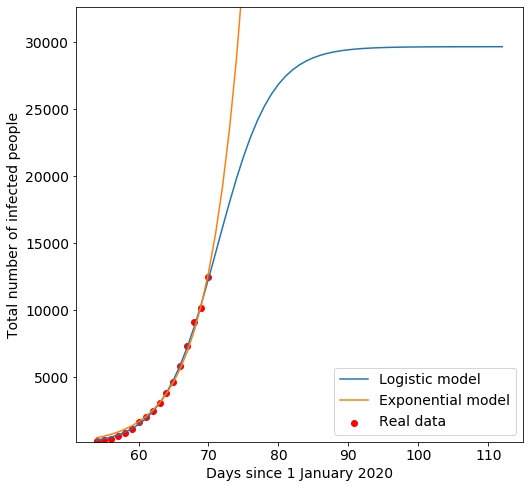

In [437]:
plt.rcParams['figure.figsize'] = [8,8]

plt.rc('font', size=14)
pred_x = list(range(max(x),sol))

plt.scatter(x,y,label="Real data", color="red")
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" )
# Predicted exponential curve
plt.plot(x+pred_x, [exponential_model(i,exp_fit[0][0],exp_fit[0][1],exp_fit[0][2]) for i in x+pred_x], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 1 January 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y)*0.9,c*1.1));

British data as per GOV website

In [444]:
df2 = pd.read_csv("DailyConfirmedCases-11Mar2020.csv")

In [445]:
df2

,DateVal,CMODateCount,CumCases
0,31/01/2020,2,2
1,01/02/2020,0,2
2,02/02/2020,0,2
3,03/02/2020,0,2
4,04/02/2020,0,2
5,05/02/2020,0,2
6,06/02/2020,1,3
7,07/02/2020,0,3
8,08/02/2020,0,3
9,09/02/2020,1,4


In [446]:
format = '%d/%m/%Y'
df2 = df2.loc[:,['DateVal', 'CumCases']]
df2['DateVal'] =  pd.to_datetime(df2['DateVal'], format=format)

In [447]:
#df2 = df2[df2['DateVal'] >= datetime(2020,2,9)]
firstDate = df2['DateVal'].iloc[0]
firstDate

Timestamp('2020-01-31 00:00:00')

In [448]:
df2_date = df2['DateVal']
df2['Days'] = df2_date.map(lambda x : (x - firstDate).days)

In [449]:
df2 = df2.append({'DateVal': datetime(2020,3,11), 'CumCases': 456, 'Days': 40}, ignore_index=True)

In [450]:
x2 = list(df2.iloc[:,2])
y2 = list(df2.iloc[:,1])

In [451]:
fit2 = curve_fit(logistic_model,x2,y2,p0=[2.6,73,2000])

In [452]:
fit2

(array([  2.83903102,  38.71876152, 736.15446391]),
 array([[1.76652105e-02, 5.82000644e-02, 7.19064337e+00],
        [5.82000644e-02, 2.21233541e-01, 2.77329877e+01],
        [7.19064337e+00, 2.77329877e+01, 3.52054788e+03]]))

In [453]:
# infection end day
a2 = fit2[0][0]
b2 = fit2[0][1]
c2 = fit2[0][2]
sol2 = int(fsolve(lambda x : logistic_model(x,a2,b2,c2) - int(c2), b2))
a2,b2,c2
exp_fit2 = curve_fit(exponential_model,x2,y2,p0=[.1,0.2,0.5])
exp_fit2

(array([0.13090851, 0.23079365, 4.46745778]),
 array([[3.79581271e+09, 2.54611314e+02, 1.25635730e+11],
        [2.54611316e+02, 6.01080504e-05, 8.42726047e+03],
        [1.25635730e+11, 8.42726042e+03, 4.15835496e+12]]))

In [454]:
sol2
max(x2)
x2_plus = list(range(max(x2),max(x2)+10))
x2_plus

[40, 41, 42, 43, 44, 45, 46, 47, 48, 49]

In [455]:
[exponential_model(i,exp_fit2[0][0],exp_fit2[0][1],exp_fit2[0][2]) for i in x2_plus]

[476.9580697515017,
 600.7760494966209,
 756.7370897756583,
 953.1855065160246,
 1200.6317941962673,
 1512.3149642757537,
 1904.9108662855401,
 2399.4243885766846,
 3022.3132737558835,
 3806.9036758184448]

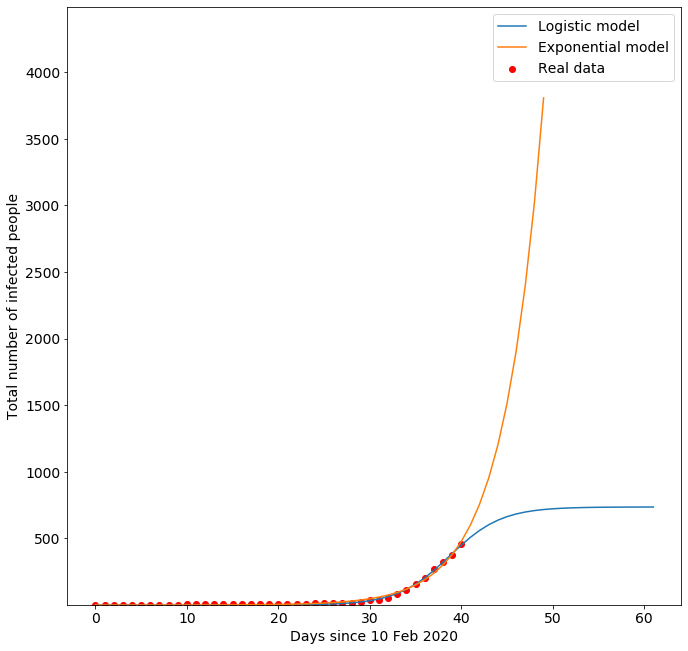

In [456]:
plt.rcParams['figure.figsize'] = [11,11]

plt.rc('font', size=14)
pred_x2 = list(range(max(x2),sol2))

plt.scatter(x2,y2,label="Real data", color="red")
plt.plot(x2+pred_x2, [logistic_model(i,fit2[0][0],fit2[0][1],fit2[0][2]) for i in x2+pred_x2], label="Logistic model" )
# Predicted exponential curve
plt.plot(x2+x2_plus, [exponential_model(i,exp_fit2[0][0],exp_fit2[0][1],exp_fit2[0][2]) for i in x2+x2_plus], label="Exponential model" )
plt.legend()
plt.xlabel("Days since 10 Feb 2020")
plt.ylabel("Total number of infected people")
plt.ylim((min(y2)*0.9,c2*6.1));

In [184]:
sol2

57

# johns hopkins data
https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports

https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

In [217]:
df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [220]:
df_confirmed.head(5)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,413,414,414,418,418,422,426,428,428,429
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,102,119,120,124,124,125


In [224]:
id_list = df_confirmed.columns.to_list()[:4]
vars_list = df_confirmed.columns.to_list()[4:]
df_confirmed_clean = pd.melt(df_confirmed, id_vars=id_list,value_vars=vars_list, var_name='Date', value_name='Confirmed')

In [225]:
df_confirmed_clean.head(5)

,Province/State,Country/Region,Lat,Long,Date,Confirmed
0,Anhui,Mainland China,31.8257,117.2264,1/22/20,1
1,Beijing,Mainland China,40.1824,116.4142,1/22/20,14
2,Chongqing,Mainland China,30.0572,107.8740,1/22/20,6
3,Fujian,Mainland China,26.0789,117.9874,1/22/20,1
4,Gansu,Mainland China,36.0611,103.8343,1/22/20,0
